# Comparison of lens curvature measurements 
- Anastasia measured the radius of curvature for the 29 lenses of the right eye. 
    - **NOTE**: The lens was damaged in six ommatidia of specimen 1: C4, D4, D6, D7, E5, E7 (n=23). AM replaced measurements of thickness, curvature, lens, diameter, cone length and width from another specimen. 
- Jing Peng measured radius of curvature for each lens by fitting circles on a prob map from Ilastik px classification.
    - For his first attempt, he accidentally did this on the wrong (Left) eye. All the lenses of the left eye were intact in the EM data (hence n=29).
    - Measurements were performed on the other (right) eye in May 2021. For the right eye, JP excluded the same set of ommatidia as Anastasia, in addition to C6 (hence n=22). JP also measured the minimum distance between the inner surface of the lens and the rhabdom. 
 
1. Compare measurements obtained by Anastasia and Jing Peng
2. Compare optics of the left and right eyes 

In [1]:
import math
import numpy as np
from typing import List
import os.path
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
import statsmodels.api as sm

from src.utils import index_by_om
from src.dataframe_tools import assemble_cxvectors
from vis.fig_tools import linear_cmap, subtype_cm
from vis.hex_lattice import hexplot_TEST, hexplot

In [2]:
plt.rcdefaults()
#plt.style.use('vis/lamina.mplstyle')
### SAVE FIGS? ###
save_figs=False
##################
# if save_figs:
#     fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/FNAME.svg')
#     fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/FNAME.png')


In [3]:
am_df = pd.read_excel('~/Data/data for ligh prop.xlsx', index_col=0)
am_df = am_df.iloc[:29] # remove last two lines of excel file
# Add pre-computed rhabdom lengths (from rhabdomere_lengths.ipynb)
rh_len = pd.read_pickle('~/Dropbox/Data/201123_rh_len_df.pickle')
for i, v in rh_len.iterrows():
    am_df.loc[i, 'rhabdom_len'] = float(v)
display(am_df)

<ipython-input-3-e4690d5b8895>:1: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  am_df = pd.read_excel('~/Data/data for ligh prop.xlsx', index_col=0)


,facet diameter (stack),lense thickness,outer curvature,inner curvature,cone length (from the tip),cone width (under the lense tip),D rhabdom dist.,D rhabdom prox.,rhabdom_len
E7,6.923,2.60900,2.219000,1.059000,3.26300,4.630000,1.782745,1.247685,13.960
E6,6.98073,2.96461,3.075507,1.506532,3.40063,5.523305,2.262045,1.454785,13.352
E5,9.263,3.64300,3.818000,2.765000,4.94300,6.648000,2.417245,2.116145,11.088
E4,8.07757,2.65285,4.636710,3.762965,3.67528,6.701025,2.970095,2.274005,12.704
D7,6.396,2.15800,2.969000,0.926000,2.82000,4.681000,1.917540,1.261355,14.032
D6,7.234,2.52200,3.042000,1.363000,2.86938,4.580985,1.980355,1.238485,13.976
D5,8.16472,3.58905,4.107682,2.415439,3.73574,6.450405,2.444485,2.152785,13.520
D4,8.028,3.83100,4.619000,2.510000,5.29000,6.910000,2.918445,2.018030,13.792
D3,7.2377,2.80608,5.070646,3.926605,3.96908,6.664940,2.949440,2.042290,14.640
D2,7.33428,2.86169,5.445023,3.446124,3.75099,6.633140,2.968950,2.206545,13.760


In [4]:
# Load Jing Peng's measurements for lens interal/external center coords and curvature
with open(os.path.expanduser('~/Data/210521_jp_optics_measurements.json')) as fh:
    jp_data = json.load(fh)
jp_df = pd.DataFrame(jp_data)

# Convert JP's radii of curvature / distances from nm to microns
jp_df[['radii_in', 'radii_out', 'distances']] = jp_df[['radii_in', 'radii_out', 'distances']] / 1000.0
# Compute lens thickness with internal/external center coordinates
dist = lambda p1, p2: np.linalg.norm(p1 - p2)

lens_thickness = [] 
for p1, p2 in zip(jp_df['centers_in'], jp_df['centers_out']):
    lens_thickness.append(dist(np.array(p1), np.array(p2)) / 1000.0)  # nm -> um
jp_df['lens_thickness'] = lens_thickness

display(jp_df['lens_thickness'])

1     1.958977
2     4.050188
3     2.077892
4     4.245302
5     2.025294
6     2.346242
7     4.364703
8     1.814770
9     0.929019
10    4.224526
11    3.500076
12    4.087695
13    1.727541
14    4.176456
15    3.332061
16    3.969363
17    3.285871
18    3.802899
19    2.524333
20    3.886083
21    3.689188
22    4.738650
23    1.696392
24    2.455460
25    2.086297
26    2.346211
27    5.102781
28    3.100927
29    2.806675
51    1.000267
52    1.958112
53    1.739368
54    4.036826
55    2.281621
56    2.116067
57    3.360253
59    4.493954
60    3.303503
61    5.260185
62    4.539210
63    4.516140
64    5.330550
65    4.732377
66    5.333149
67    5.532118
68    4.764852
69    4.989782
70    4.284310
71    4.925465
72    4.978672
73    5.747799
Name: lens_thickness, dtype: float64

In [5]:
### RIGHT EYE ###
right_om_labels = {'A0': 73, 'B0': 72, 
                  'A1': 71, 'B1': 70, 'C1': 69, 
                  'A2': 68, 'B2': 67, 'C2': 66, 'D2': 65, 
                  'A3': 64, 'B3': 63, 'C3': 61, 'D3': 62, 
                  'A4': 60, 'B4': 57, 'E4': 59,  
                  'A5': 56, 'B5': 55, 'C5': 54, 'D5': 53,
                  'B6': 52, 'E6': 51}
# Make sure indices are unique for each om
assert(len(right_om_labels.keys()) == len(set(right_om_labels.values())))

right_inverted = {str(v): k for k, v in right_om_labels.items()}
right_indices = [str(v) for k, v in right_om_labels.items()]
jp_right = jp_df.loc[right_indices]
jp_right = jp_right.rename(index=right_inverted)


# Re-order Anastasia's data to match JP's right eye measurements
# Remove c6 (excluded in JP's measurements)
am_right = am_df.loc[jp_right.index]

In [6]:
### LEFT EYE ###
left_om_labels = {'A0': 12, 'B0': 19, 
             'A1': 11, 'B1': 21, 'C1': 26,
             'A2': 7, 'B2': 17, 'C2': 24, 'D2': 28, 
             'A3': 4, 'B3': 15, 'C3': 23, 'D3': 29, 
             'A4': 2, 'B4': 10, 'C4': 18, 'D4': 25, 'E4': 27, 
             'A5': 1, 'B5': 6, 'C5': 14, 'D5': 20, 'E5': 22, 
             'B6': 3, 'C6': 9, 'D6': 13, 'E6': 16, 
             'D7': 5, 'E7': 8}
# Make sure indices are unique for each om
assert(len(left_om_labels.keys()) == len(set(left_om_labels.values())))

left_inverted = {str(v): k for k, v in left_om_labels.items()}
left_indices = [str(v) for k, v in left_om_labels.items()]
jp_left = jp_df.loc[left_indices]
jp_left = jp_left.rename(index=left_inverted)

In [7]:
ommatidia = list(left_om_labels)

In [8]:
dra_c = '#434371'
ndra_c = '#C64191'
dra_m = '^'
ndra_m = 'v'

dra_om = ['A4', 'A5', 'B5', 'B6', 'C5', 'C6', 'D6', 'D7', 'E6', 'E7']
ndra_om = [o for o in ommatidia if o not in dra_om]
assert(len(dra_om) + len(ndra_om) == 29)

def om_colors(om_list: List, dra_om: List=dra_om, as_rgb: bool=False, 
              dra_c: str=dra_c, ndra_c: str=ndra_c) -> List:
    
    c_list = []
    for o in om_list:
        if str(o) in dra_om:
            c_list.append(dra_c)
        else:
            c_list.append(ndra_c)
    if as_rgb:
        return [tuple(int(h.lstrip('#')[i:i+2], 16)/255.0 for i in (0, 2, 4)) for h in c_list] 
    else:
        return c_list
    
def om_markers(om_list: List, dra_om: List=dra_om, 
               dra_m: str=dra_m, ndra_m: str=ndra_m) -> List:
    
    m_list = []
    for o in om_list:
        if o in dra_om:
            m_list.append(dra_m)
        else:
            m_list.append(ndra_m)
            
    return m_list

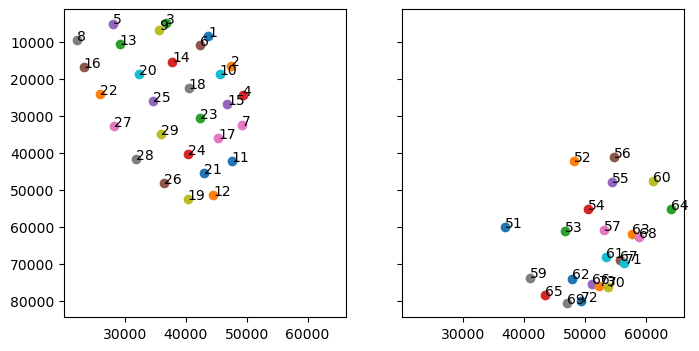

In [9]:
fig, ax = plt.subplots(1, 2, figsize=[8, 4], sharex=True, sharey=True)

for i, row in jp_df.iterrows():
    x, y, z = row['centers_out']
    if int(i) <= 29:
        # LEFT
        ax[0].scatter(x, y)
        ax[0].annotate(i, (x, y))
    else:
        ax[1].scatter(x, y)
        ax[1].annotate(i, (x, y))
ax[0].invert_yaxis()


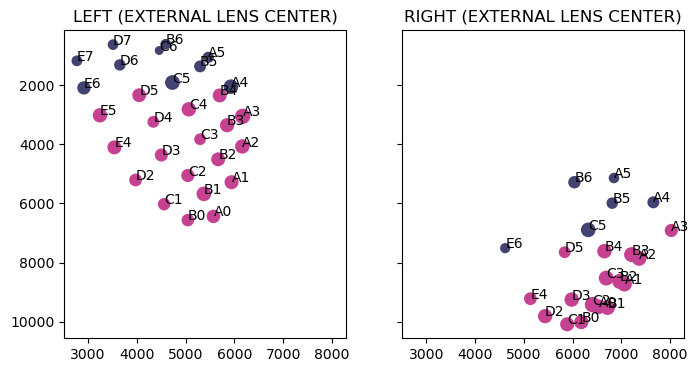

In [10]:
fig, ax = plt.subplots(1, 2, figsize=[8, 4], sharex=True, sharey=True)


x = [c[0] / 8.0 for c in jp_left['centers_out']]
y = [c[1] / 8.0 for c in jp_left['centers_out']]
ax[0].scatter(x, y, s=jp_left['radii_out'] * 20.0, c=om_colors(jp_left.index))
for i, row in jp_left.iterrows():
    ax[0].annotate(i, (row['centers_out'][0] / 8.0, row['centers_out'][1] / 8.0))

x = [c[0] / 8.0 for c in jp_right['centers_out']]
y = [c[1] / 8.0 for c in jp_right['centers_out']]
ax[1].scatter(x, y, s=jp_right['radii_out'] * 20.0, c=om_colors(jp_right.index))
for i, row in jp_right.iterrows():
    ax[1].annotate(i, (row['centers_out'][0] / 8.0, row['centers_out'][1] / 8.0))
    
ax[0].set_title('LEFT (EXTERNAL LENS CENTER)')
ax[1].set_title('RIGHT (EXTERNAL LENS CENTER)')
plt.gca().invert_yaxis()
    
plt.show()

## Right eye: AM vs JP lens curvature measurements

Text(0.5, 1.0, 'Inner radius of curvature (n=22)')

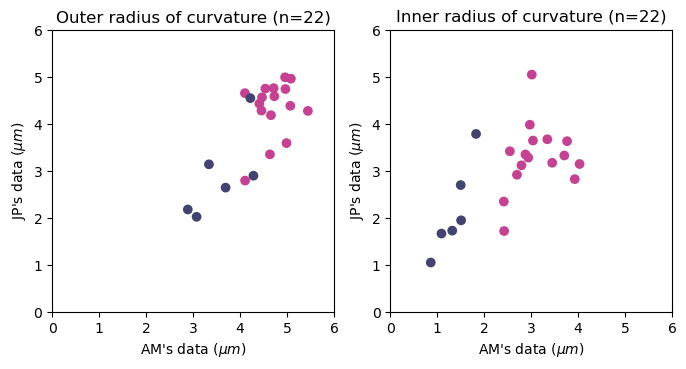

In [11]:
fig, ax = plt.subplots(1, 2, figsize=[8, 4])

x = am_right.loc[:, 'outer curvature']
y = jp_right.loc[:, 'radii_out']
assert(all([i == j for i, j in zip(am_right.index, jp_right.index)]))
group_c = om_colors(am_right.index)
ax[0].scatter(x, y, c=group_c)
ax[0].set_xlim([0.0, 6.0])
ax[0].set_ylim([0.0, 6.0])
ax[0].set_xlabel(r"AM's data ($\mu m$)")
ax[0].set_ylabel(r"JP's data ($\mu m$)")
ax[0].set_aspect('equal')
ax[0].set_title(f'Outer radius of curvature (n={len(x)})')


x = am_right.loc[:, 'inner curvature']
y = jp_right.loc[:, 'radii_in']
ax[1].scatter(x, y, c=group_c)
ax[1].set_xlim([0.0, 6.0])
ax[1].set_ylim([0.0, 6.0])
ax[1].set_xlabel(r"AM's data ($\mu m$)")
ax[1].set_ylabel(r"JP's data ($\mu m$)")
ax[1].set_aspect('equal')
ax[1].set_title(f'Inner radius of curvature (n={len(x)})')



Text(0.5, 1.0, 'JP (n=22)')

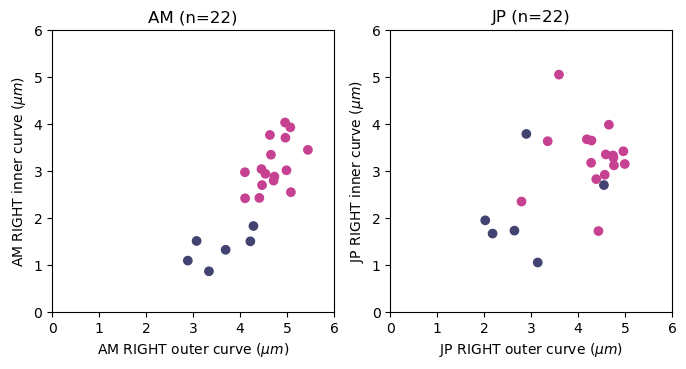

In [12]:
fig, ax = plt.subplots(1, 2, figsize=[8, 4])

x = am_right.loc[:, 'outer curvature']
y = am_right.loc[:, 'inner curvature']

group_c = om_colors(am_right.index)
ax[0].scatter(x, y, c=group_c)
ax[0].set_xlim([0.0, 6.0])
ax[0].set_ylim([0.0, 6.0])
ax[0].set_xlabel(r"AM RIGHT outer curve ($\mu m$)")
ax[0].set_ylabel(r"AM RIGHT inner curve ($\mu m$)")
ax[0].set_aspect('equal')
ax[0].set_title(f'AM (n={len(x)})')


x = jp_right.loc[:, 'radii_out']
y = jp_right.loc[:, 'radii_in']
ax[1].scatter(x, y, c=group_c)
ax[1].set_xlim([0.0, 6.0])
ax[1].set_ylim([0.0, 6.0])
ax[1].set_xlabel(r"JP RIGHT outer curve ($\mu m$)")
ax[1].set_ylabel(r"JP RIGHT inner curve ($\mu m$)")
ax[1].set_aspect('equal')
ax[1].set_title(f'JP (n={len(x)})')



In [13]:
display(am_right['outer curvature'])
display(jp_right['radii_out'])

A0    4.104361
B0    4.456473
A1    4.539853
B1    4.468678
C1    4.658214
A2    4.731129
B2    5.082763
C2    4.959154
D2    5.445023
A3    4.989014
B3    4.715047
C3    4.966403
D3    5.070646
A4    4.285955
B4    4.410941
E4    4.636710
A5    2.888274
B5    3.692992
C5    4.219751
D5    4.107682
B6    3.338393
E6    3.075507
Name: outer curvature, dtype: float64

A0    4.653592
B0    4.281909
A1    4.750297
B1    4.565100
C1    4.184439
A2    4.587835
B2    4.961245
C2    4.991327
D2    4.275189
A3    3.590336
B3    4.760887
C3    4.740711
D3    4.383915
A4    2.895273
B4    4.430409
E4    3.350345
A5    2.176745
B5    2.642230
C5    4.547252
D5    2.792726
B6    3.138212
E6    2.020725
Name: radii_out, dtype: float64

Ommatidia with the largest diff between AM and JP:
- A4 Outer curvature: A4's outer lens surface looks like it has similar radius of curvature to A3 and B3. In JP's data, A4 has a very small radius of curvature compared to A3 and B3, while AM's A4 is very close. AM looks more correct
- D5 Outer curvature: D5 

A3    1.398678
A4    1.390682
D5    1.314956
E4    1.286365
D2    1.169834
E6    1.054782
B5    1.050762
A5    0.711529
D3    0.686731
A0    0.549231
C1    0.473775
C5    0.327501
C3    0.225692
A1    0.210444
B6    0.200181
B0    0.174564
A2    0.143294
B2    0.121518
B1    0.096422
B3    0.045840
C2    0.032173
B4    0.019468
dtype: float64

/mnt/home/nchua/miniconda3/envs/wasp-lite/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


A3    2.037151
A4    1.960106
C5    1.198109
D3    1.103675
A0    1.011082
C2    0.883903
B2    0.871283
B4    0.705155
B0    0.607945
A5    0.575798
A2    0.472049
E6    0.439402
B5    0.408309
C3    0.377734
A1    0.343759
C1    0.329101
B3    0.325063
D2    0.275138
B1    0.219759
B6    0.186862
E4    0.132228
D5    0.069622
dtype: float64

Text(0.5, 0, 'RIGHT EYE: AM - JP ($\\mu m$)')

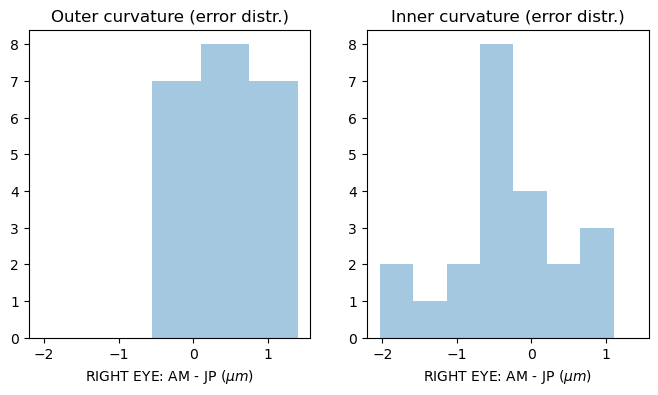

In [14]:
fig, ax = plt.subplots(1, 2, figsize=[8, 4], sharex=True)

x = am_right.loc[:, 'outer curvature']
y = jp_right.loc[:, 'radii_out']
err = x-y
display(abs(err).sort_values(ascending=False))
sns.distplot(err, ax=ax[0], kde=False)
ax[0].set_title('Outer curvature (error distr.)')
ax[0].set_xlabel('RIGHT EYE: AM - JP ($\mu m$)')



x = am_right.loc[:, 'inner curvature']
y = jp_right.loc[:, 'radii_in']
err = x-y
display(abs(err).sort_values(ascending=False))
sns.distplot(err, ax=ax[1], kde=False)
ax[1].set_title('Inner curvature (error distr.)')
ax[1].set_xlabel('RIGHT EYE: AM - JP ($\mu m$)')



## Right eye: AM vs JP focal length and cone length

Text(0, 0.5, "JP's 'CONE LENGTH' $(\\mu m)$")

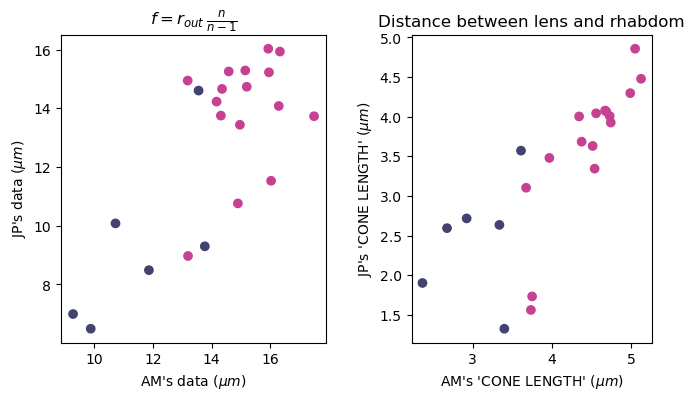

In [15]:
fig, ax = plt.subplots(1, 2, figsize=[8, 4])

# Focal length
n = 1.452 # Refraction index of Apis lens 
f_thin = lambda r_outer: r_outer * n / (n-1)
f_am = f_thin(am_right.loc[:, 'outer curvature'])
f_jp = f_thin(jp_right.loc[:, 'radii_out'])

ax[0].scatter(f_am, f_jp, c=group_c)
ax[0].set_aspect('equal')
ax[0].set_title(r"$f = r_{out}\:\frac{n}{n-1}$")
ax[0].set_xlabel(r"AM's data $(\mu m)$")
ax[0].set_ylabel(f"JP's data $(\mu m)$")

# Distance between lens and rhabdom
dist_am = am_right.loc[:, 'cone length (from the tip)']
dist_jp = jp_right.loc[:, 'distances']
ax[1].scatter(dist_am, dist_jp, c=group_c)
ax[1].set_aspect('equal')
ax[1].set_title(r"Distance between lens and rhabdom")
ax[1].set_xlabel(r"AM's 'CONE LENGTH' $(\mu m)$")
ax[1].set_ylabel(f"JP's 'CONE LENGTH' $(\mu m)$")


## LEFT VS RIGHT

In [16]:
## FOR LEFT RIGHT COMPARISONS, GET RID OF OMMATIDIA EXCLUDED IN RIGHT EYE
jp_left_in_r = jp_left.loc[jp_right.index]

Text(0.5, 1.0, 'Inner radius of curvature (n=22)')

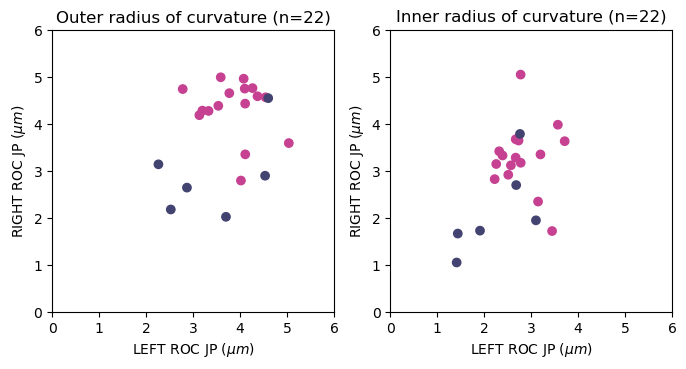

In [17]:
fig, ax = plt.subplots(1, 2, figsize=[8, 4])

x = jp_left_in_r.loc[:, 'radii_out']
y = jp_right.loc[:, 'radii_out']
assert(all([i == j for i, j in zip(am_right.index, jp_right.index)]))
group_c = om_colors(am_right.index)
ax[0].scatter(x, y, c=group_c)
ax[0].set_xlim([0.0, 6.0])
ax[0].set_ylim([0.0, 6.0])
ax[0].set_xlabel(r"LEFT ROC JP ($\mu m$)")
ax[0].set_ylabel(r"RIGHT ROC JP ($\mu m$)")
ax[0].set_aspect('equal')
ax[0].set_title(f'Outer radius of curvature (n={len(x)})')


x = jp_left_in_r.loc[:, 'radii_in']
y = jp_right.loc[:, 'radii_in']
ax[1].scatter(x, y, c=group_c)
ax[1].set_xlim([0.0, 6.0])
ax[1].set_ylim([0.0, 6.0])
ax[1].set_xlabel(r"LEFT ROC JP ($\mu m$)")
ax[1].set_ylabel(r"RIGHT ROC JP ($\mu m$)")
ax[1].set_aspect('equal')
ax[1].set_title(f'Inner radius of curvature (n={len(x)})')



left fano = 0.13587628804537627


Text(0.5, 1.0, 'Inner radius of curvature (n=22)')

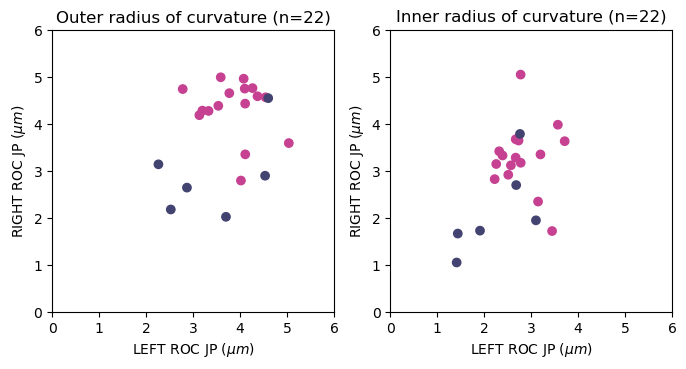

In [18]:
fig, ax = plt.subplots(1, 2, figsize=[8, 4])

x = jp_left_in_r.loc[:, 'radii_out']
y = jp_right.loc[:, 'radii_out']
assert(all([i == j for i, j in zip(am_right.index, jp_right.index)]))
group_c = om_colors(am_right.index)
ax[0].scatter(x, y, c=group_c)
ax[0].set_xlim([0.0, 6.0])
ax[0].set_ylim([0.0, 6.0])
ax[0].set_xlabel(r"LEFT ROC JP ($\mu m$)")
ax[0].set_ylabel(r"RIGHT ROC JP ($\mu m$)")
ax[0].set_aspect('equal')
ax[0].set_title(f'Outer radius of curvature (n={len(x)})')

print(f'left fano = {x.var(ddof=0)/x.mean()}')

x = jp_left_in_r.loc[:, 'radii_in']
y = jp_right.loc[:, 'radii_in']
ax[1].scatter(x, y, c=group_c)
ax[1].set_xlim([0.0, 6.0])
ax[1].set_ylim([0.0, 6.0])
ax[1].set_xlabel(r"LEFT ROC JP ($\mu m$)")
ax[1].set_ylabel(r"RIGHT ROC JP ($\mu m$)")
ax[1].set_aspect('equal')
ax[1].set_title(f'Inner radius of curvature (n={len(x)})')



A5   -0.100266
A3    0.112102
B6    0.344506
A4    0.508010
E6    0.582437
B5    0.732434
A2    0.932066
B3    0.939214
C1    0.980037
C5    1.134129
B4    1.174220
A1    1.191340
C2    1.211971
B2    1.248206
E4    1.412862
A0    1.426577
B0    1.430389
C3    1.468150
D3    1.533960
B1    1.906377
D5    2.349957
D2    3.243590
Name: distances, dtype: float64

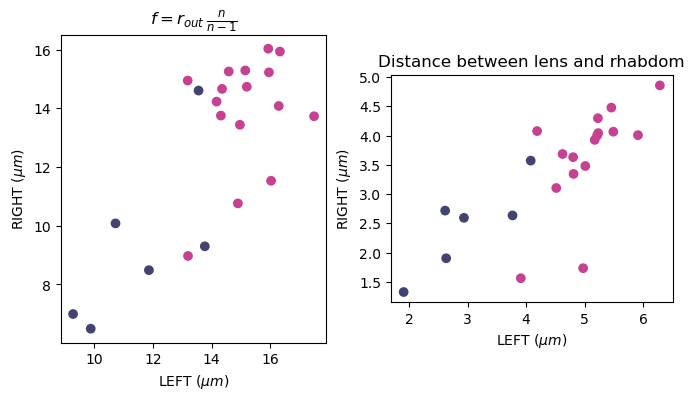

In [22]:
fig, ax = plt.subplots(1, 2, figsize=[8, 4])

# Focal length
n = 1.452 # Refraction index of Apis lens 
f_thin = lambda r_outer: r_outer * n / (n-1)
f_left = f_thin(jp_left_in_r.loc[:, 'radii_out'])
f_jp = f_thin(jp_right.loc[:, 'radii_out'])

ax[0].scatter(f_am, f_jp, c=group_c)
ax[0].set_aspect('equal')
ax[0].set_title(r"$f = r_{out}\:\frac{n}{n-1}$")
ax[0].set_xlabel(r"LEFT $(\mu m)$")
ax[0].set_ylabel(f"RIGHT $(\mu m)$")

# Distance between lens and rhabdom
dist_am = jp_left_in_r.loc[:, 'distances']
dist_jp = jp_right.loc[:, 'distances']
ax[1].scatter(dist_am, dist_jp, c=group_c)
ax[1].set_aspect('equal')
ax[1].set_title(r"Distance between lens and rhabdom")
ax[1].set_xlabel(r"LEFT $(\mu m)$")
ax[1].set_ylabel(f"RIGHT $(\mu m)$")

display((dist_am-dist_jp).sort_values())


## Correlation of focal length and distance between lens and rhabdom

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     13.53
Date:                Wed, 16 Jun 2021   Prob (F-statistic):            0.00149
Time:                        18:12:20   Log-Likelihood:                -41.657
No. Observations:                  22   AIC:                             87.31
Df Residuals:                      20   BIC:                             89.50
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.1509      1.934      3.697      0.001       3.116      11.186
x1             1.7128      0.466      3.678      0.001       0.741       2.684
==============================================================================
Omnibus:                        0.682   Durbin-Watson:                   1.219
Prob(Omnibus):                  0.711   Jarque-Bera (JB):                0.103
Skew:                           0.153   Prob(JB):                        0.950
Kurtosis:                       3.137   Cond. No.                         23.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

[7.15091925 1.71278566]


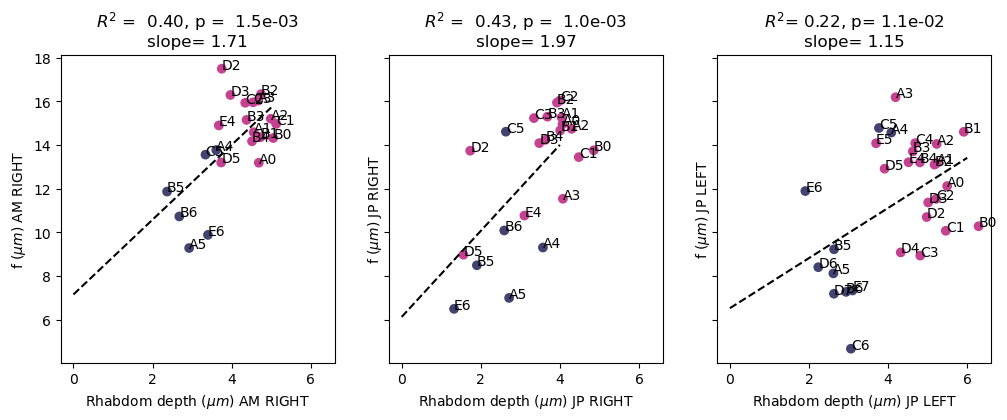

In [23]:


fig, ax = plt.subplots(1, 3, figsize=[12, 4], sharex=True, sharey=True)

n = 1.452 # Refraction index of Apis lens 
f_thin = lambda r_outer: r_outer * n / (n-1)

# ~~~~~~~~~~ AM RIGHT ~~~~~~~~~~~~
f = []
d = []
group_c = om_colors(am_right.index)
for om, row in am_right.iterrows():  # replace with am_df to include C6
    f.append(f_thin(row['outer curvature']))
    d.append(row['cone length (from the tip)'])
    ax[0].annotate(om, (row['cone length (from the tip)'], f_thin(row['outer curvature'])))
_x = d
X = sm.add_constant(_x)
Y = f

model = sm.OLS(Y, X)
results = model.fit()
params = results.params
display(results.summary())
print(params)

ax[0].scatter(x=_x, y=Y, marker='o', c=group_c)
ax[0].set_title(f'$R^{2}$ = {results.rsquared: .2f}, p = {results.f_pvalue: .1e}\n' +
                f'slope={params[1]: .2f}')
ax[0].set_xlabel('Rhabdom depth ($\mu{m}$) AM RIGHT')
ax[0].set_ylabel("f ($\mu{m}$) AM RIGHT")

xx = np.arange(0, max(_x))
ax[0].plot(xx, params[1] * xx + params[0], c='k', ls='--')

# ~~~~~~~~~~ JP RIGHT ~~~~~~~~~~~~
f = []
d = []
group_c = om_colors(jp_right.index)
for om, row in jp_right.iterrows():  # replace with am_df to include C6
    f.append(f_thin(row['radii_out']))
    d.append(row['distances'])
    ax[1].annotate(om, (row['distances'], f_thin(row['radii_out'])))
_x = d
X = sm.add_constant(_x)
Y = f

model = sm.OLS(Y, X)
results = model.fit()
params = results.params

ax[1].scatter(x=_x, y=Y, marker='o', c=group_c)
#ax[1].annotate(jp_right.index, (_x, Y))
ax[1].set_title(f'$R^{2}$ = {results.rsquared: .2f}, p = {results.f_pvalue: .1e}\n' +
                f'slope={params[1]: .2f}')
ax[1].set_xlabel('Rhabdom depth ($\mu{m}$) JP RIGHT')
ax[1].set_ylabel("f ($\mu{m}$) JP RIGHT")

xx = np.arange(0, max(_x))
ax[1].plot(xx, params[1] * xx + params[0], c='k', ls='--')

# ~~~~~~~~~~ JP LEFT ~~~~~~~~~~~~
f = []
d = []
group_c = om_colors(jp_left.index)
for om, row in jp_left.iterrows():  # replace with am_df to include C6
    f.append(f_thin(row['radii_out']))
    d.append(row['distances'])
    ax[2].annotate(om, (row['distances'], f_thin(row['radii_out'])))
_x = d
X = sm.add_constant(_x)
Y = f

model = sm.OLS(Y, X)
results = model.fit()
params = results.params

ax[2].scatter(x=_x, y=Y, marker='o', c=group_c)
#ax[1].annotate(jp_right.index, (_x, Y))
ax[2].set_title(f'$R^{2}$={results.rsquared: .2f}, p={results.f_pvalue: .1e}\n' +
                f'slope={params[1]: .2f}')
ax[2].set_xlabel('Rhabdom depth ($\mu{m}$) JP LEFT')
ax[2].set_ylabel("f ($\mu{m}$) JP LEFT")

xx = np.arange(0, max(_x))
ax[2].plot(xx, params[1] * xx + params[0], c='k', ls='--')


## Thick lens equation

In [26]:
def f_thick(r_outer: float, r_inner: float, t: float) -> float:
    # For a bi convex lens, r_inner is negative
    r_inner = -1.0 * r_inner
    
    nl = 1.452 # lens
    nc = 1.348 # cone
    # lens power IN MICROMETERS
    p1 = (nl - 1.0)/r_outer # interface air->lens 
    p2 = (nc - nl)/r_inner # interface lens->cone\
    p3 = (t/nl) * p1 * p2
    #p = p1 + p2
    p = p1 + p2 - p3
    
    return 1.0/p


Text(0, 0.5, 'f (thick eq) JP RIGHT')

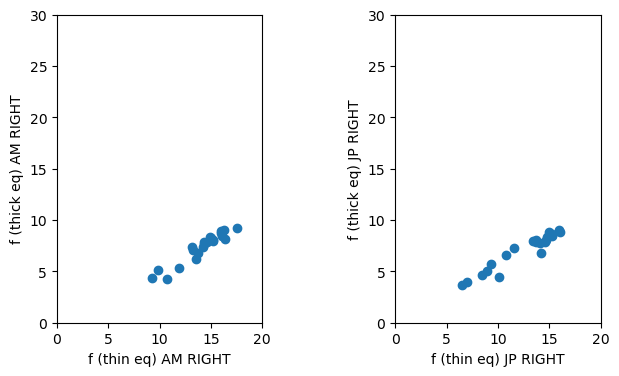

In [27]:
fig, ax = plt.subplots(1, 2, figsize=[8, 4],)

x = f_thin(am_right['outer curvature'])
y = [f_thick(o, i, t) for o, i, t in zip(am_right['outer curvature'], am_right['inner curvature'], am_right['lense thickness'])]
labels = [str(i) for i in am_right.index]

ax[0].scatter(x, y)
#ax[0].annotate(labels, (x, y))

ax[0].set_aspect('equal')
ax[0].set_xlim([0, 20])
ax[0].set_ylim([0, 30])
ax[0].set_xlabel('f (thin eq) AM RIGHT')
ax[0].set_ylabel('f (thick eq) AM RIGHT')


x = f_thin(jp_right['radii_out'])
y = [f_thick(o, i, t) for o, i, t in zip(jp_right['radii_out'], jp_right['radii_in'], jp_right['lens_thickness'])]
labels = [str(i) for i in jp_right.index]

ax[1].scatter(x, y)
#ax[1].annotate(labels, (x, y))

ax[1].set_aspect('equal')
ax[1].set_xlim([0, 20])
ax[1].set_ylim([0, 30])
ax[1].set_xlabel('f (thin eq) JP RIGHT')
ax[1].set_ylabel('f (thick eq) JP RIGHT')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     33.27
Date:                Wed, 16 Jun 2021   Prob (F-statistic):           1.21e-05
Time:                        18:13:40   Log-Likelihood:                -31.923
No. Observations:                  22   AIC:                             67.85
Df Residuals:                      20   BIC:                             70.03
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0756      1.243      0.061      0.952      -2.517       2.668
x1             1.7258      0.299      5.768      0.000       1.102       2.350
==============================================================================
Omnibus:                        0.312   Durbin-Watson:                   1.820
Prob(Omnibus):                  0.856   Jarque-Bera (JB):                0.481
Skew:                          -0.154   Prob(JB):                        0.786
Kurtosis:                       2.345   Cond. No.                         23.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

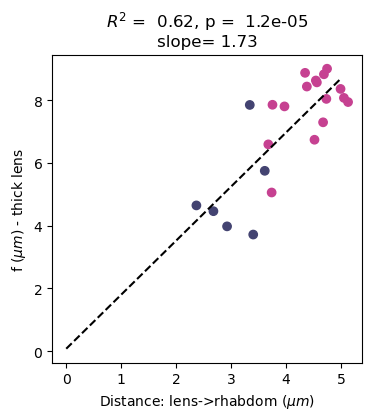

In [28]:
fig, ax = plt.subplots(1, figsize=[4, 4], sharex=True, sharey=True)

f = [f_thick(o, i, t) for o, i, t in zip(jp_right['radii_out'], jp_right['radii_in'], jp_right['lens_thickness'])]
d = [am_right.loc[om, 'cone length (from the tip)'] for om in jp_right.index]
region_c = om_colors(jp_right.index)
region_m = om_markers(jp_right.index)

_x = d
X = sm.add_constant(_x)
Y = f

# REGRESSION
model = sm.OLS(Y, X)
results = model.fit()
params = results.params
display(results.summary())

ax.scatter(x=_x, y=Y, color=region_c)
ax.set_title(f'$R^{2}$ = {results.rsquared: .2f}, p = {results.f_pvalue: .1e}\n' +
                f'slope={params[1]: .2f}')
ax.set_xlabel('Distance: lens->rhabdom ($\mu{m}$)')
ax.set_ylabel("f ($\mu{m}$) - thick lens")

xx = np.arange(0, max(_x))
ax.plot(xx, params[1] * xx + params[0], c='k', ls='--')